## This demo provides code for visualizing attention fields in vision transformers masked auto encoders. The model's source code were modified to extract easily attention weights. This code also provide features to reproduce experiments that were done for our paper about patch properties hypotheses. Most of the code for visualization of attention is located in *attention_visualize.py*.

In [14]:

from collections import defaultdict

import torch
import torchvision.datasets as datasets
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

from visualize import to_print,visualize_mae_3pictures,visualize_neighbors,visualize_mae
from utils.load_models import load_mae
from imagenet_utils.extract_batchs import extract_batch,path_init
from utils.attention_visualize import self_att,patch_gen,draw_att,keys_to_col,create_color_dict, patch_gen_influencer,importance_over_mask,consistency,dist
#For this notebook, interesting features are in draw_att function, that control attention visualization within the image. You can consider fuzzy attention fields or hard treshold ones.



import os 

current = os.getcwd() #Directory
data_path = current + '\\imagenet'

inet_mean = [0.485, 0.456, 0.406]
inet_std = [0.229, 0.224, 0.225]

colors = create_color_dict()
n_heads = 16
patch_size = 8
img_size = 64
num_patch = int((img_size/patch_size)**2)
mix = False #Hard vs fuzzy attention fields

# Import model and data

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else('cpu')
print(device)
#Loading VitMAE model pretrained on imagenet 64*64
model = load_mae().to(device)

cuda
Model loaded.


In [3]:

extract = False
train_repo, val_repo = path_init(data_path)
if extract:
    counter,val_counter = extract_batch(data_path+'\\batchs\\',train_repo,val_repo,train=True,val=True,device='cpu') #If having a good CPU, it will run faster on it rather than gpu.
else:
    counter,val_counter = 1281167, 50000

In [4]:
img_list_inet = [val_repo + str(i)+".pt" for i in range(val_counter)]

class DATA_bis(Dataset):
    def __init__(self, img_list, transform = None, mean = None,std = None):
        self.img_list = img_list
        self.transform = transform
        self.mean = mean
        self.std = std

        if(self.mean is not None and self.std is not None):
            self.normalize = transforms.Normalize(mean=self.mean,
                         std=self.std)
        else:
            self.normalize = None
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img = torch.load(img_path)
        
        #img = img.unsqueeze(diml=0) #add a dimension (same as img = img[None,:]) #not necssary as dataloder will create batch dimension
        if self.normalize is not None:
            img = self.normalize(img)
        if self.transform is not None:
            img = self.transform(img)
        #img = torch.einsum('hwc->chw', img) #switch channel position

        return img,idx

val_dataset = DATA_bis(img_list_inet,mean=inet_mean,std=inet_std) #no transform here

val_loader = torch.utils.data.DataLoader(val_dataset,
                         batch_size=10,
                         num_workers=0, #should be increased if not working on jupyter lab
                         shuffle=False)

# Load a batch and visualize reconstruction on an image

In [5]:
device = 'cuda'
imgs_batch,idxs =  next(iter(val_loader))
imgs_batch = imgs_batch.to(device)

decoder_rel_atts, losss,ys,masks = model(imgs_batch,mask_ratio=0.75,rel_att=True,grid_idx = 0)

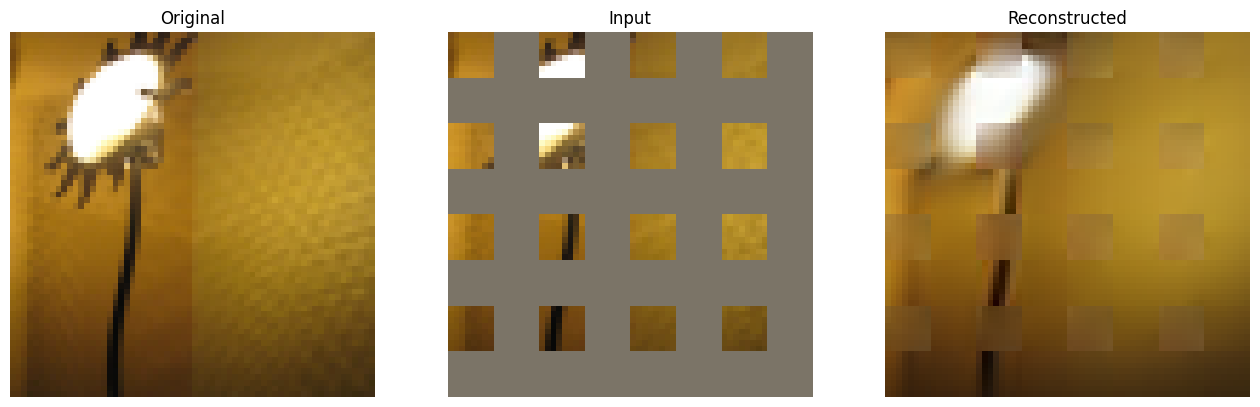

In [6]:
i=1
t = False
visualize_mae_3pictures(imgs_batch[i],ys[i],masks[i],img_size = 64,patch_size = 8,std= inet_std,mean = inet_mean)
#plt.savefig('img'+str(i)+'.pdf',dpi=300)

# Visualize Attention Fields

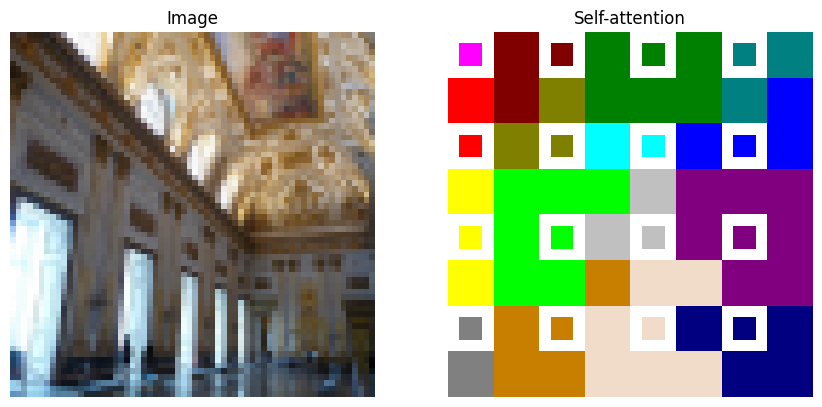

In [7]:
depth = 0 #depth
i=7 #image
n=10 #n is a hyperparameter. To compute influencers patchs (see sraw att function) we compute top-n attention weights. n do not have a big influence on results, except that increasing reduces amount of black patches.

att_map = self_att(decoder_rel_atts[i],depth,n,mix,colors,n_heads,num_patch)
figure = plt.figure(figsize=(16, 16))
printable = to_print(imgs_batch[i].detach().cpu(),inet_std,inet_mean,show=False)

figure.add_subplot(1, 3, 1)
plt.title('Image')
plt.axis("off")
plt.imshow(printable) #could need to use img.squeeze() to remove any dimension equal to 1 on the input

figure.add_subplot(1, 3, 2)
plt.title('Self-attention')
plt.axis("off")
plt.imshow(att_map) #could need to use img.squeeze() to remove any dimension equal to 1 on the input

plt.show()

# Start computation to challenge hypotheses


In [8]:
local_patches = [0,0,0,0,0,0] #dictionnary of counts of 3*3 neighboring belong for depths
consistent_samples = [0,0,0,0,0,0] #consistent dict
colored_patches = [0,0,0,0,0,0] #count black dict
count_patchs = 0
n_samples = 30 #3000 in our paper experiment
consistent_samples_count = [0,0,0,0,0,0]


mix = False

for depth in range(6):
  for img in tqdm(range(n_samples)):
    img = val_dataset.__getitem__(img)[0]

    img_batch = img.to('cuda').unsqueeze(dim=0)
    decoder_rel_att, loss,y,mask = model(img_batch,mask_ratio=0.75,rel_att=True,grid_idx=0)
    
    consistence = consistency(decoder_rel_att,mask,num_patch,n_heads,depth)
    consistent_samples[depth] += consistence
    if consistence==1:
      consistent_samples_count[depth]+=1

      att_map,field = self_att(decoder_rel_att[0],depth,5,mix,colors,n_heads,num_patch,field=True)
      colored = len([x for j in list(field.values()) for x in j]) #used to count black holes and to normalize counts (number of non black patchs)

      colored_patches[depth] += colored


      for i in list(field.keys()):
        for j in field[i]:
          d = dist(i,j)
          if d<=1.5: #local patch
            local_patches[depth]+=1
        


100%|██████████| 30/30 [00:02<00:00, 12.39it/s]


In [9]:
lp = torch.tensor(local_patches) #dictionnary of counts of 3*3 neighboring belongings for depths
cs = torch.tensor(consistent_samples)
cp = torch.tensor(colored_patches)
csc = torch.tensor(consistent_samples_count)*48

In [10]:
#if computed on every patchs
only_consistents = True
if only_consistents:
    lp = lp/cp #normalize on each depth per number of total patchs
    cp = cp/(csc) #see frecuency of total colored patch above total number of visible patches
    cs = cs/n_samples

else:
    lp = lp/cp #normalize on each depth per number of total patchs
    cp = cp/(48*n_samples) #see frecuency of total colored patch above total number of visible patches
    cs = cs/n_samples
    
lp = torch.cat((torch.tensor([0]),lp))
cp = torch.cat((torch.tensor([0]),cp))
cs = torch.cat((torch.tensor([0]),cs))

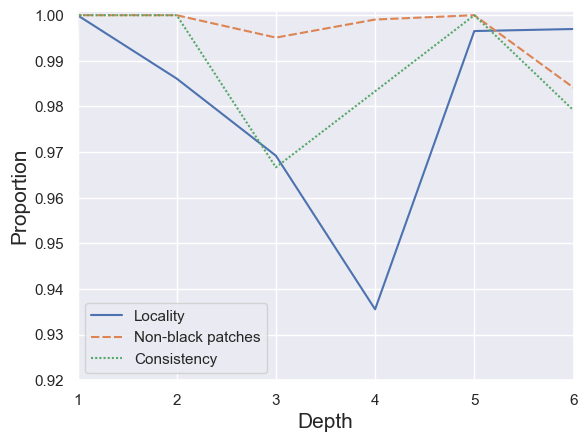

In [11]:


import pandas as pd
import seaborn as sns
df = pd.DataFrame(np.array([list(lp),list(cp),list(cs)]).transpose(),columns=['Locality', "Non-black patches","Consistency"])
sns.set(style="darkgrid")

p = sns.lineplot(data=df)
p.set_ylabel("Proportion", fontsize = 15)
p.set_xlabel("Depth", fontsize = 15)
p.set_xlim(1,6)
p.set_ylim(0.92,1.001)

plt.savefig('test.png',dpi=300) 


# Figure generation

In [12]:
def generate_schema(i):
  #Given an image, we compute its attention maps and concatenate into a figure.
  x = val_dataset.__getitem__(i)[0].unsqueeze(dim=0).to('cuda')
  decoder_rel_atts, loss,y,mask = model(x,mask_ratio=0.75,rel_att=True,grid_idx = 0)
  original,reconsplus,recons = visualize_mae(x[0],y[0],mask[0],img_size,patch_size).detach()
  
  recons = ((recons * torch.tensor(inet_std) + torch.tensor(inet_mean))*255).int()

  input = torch.clip((reconsplus * torch.tensor(inet_std) + torch.tensor(inet_mean)) * 255, 0, 255).int()
  img = ((torch.einsum('chw->hwc',x[0]).detach().cpu()*torch.tensor(inet_std) + torch.tensor(inet_mean))*255).int()

  schema = torch.cat([img,255*torch.ones(64,5,3).int(),input],1)

  for i in range(6):
    att_map = self_att(decoder_rel_atts[0],depth=i,n=5,mix=False,colors=colors,n_heads=n_heads,num_patch=num_patch)

    schema = torch.cat([schema,255*torch.ones(64,5,3).int(),att_map],1)
  
  schema = torch.cat([schema,255*torch.ones(64,5,3).int(),recons],1)
  return(schema)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


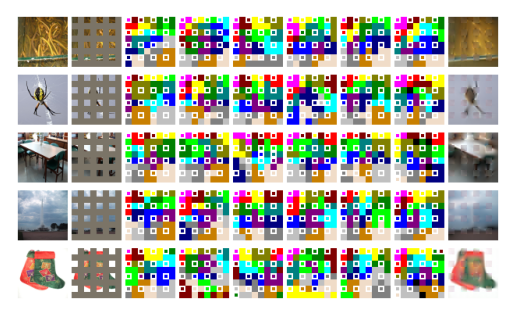

In [13]:
bs = generate_schema(np.random.randint(1000))
for i in [3,809,631,641]:
  #i=numpy.random.randint(1000)
  schema = generate_schema(i)
  bs = torch.cat([bs,255*torch.ones(10,616,3).int(),schema])
#bs = torch.tensor(bs,dtype=torch.uint8)

bs = torch.cat([255*torch.ones(10,616,3).int(),bs,255*torch.ones(10,616,3).int()])
bs = torch.cat([255*torch.ones(380,10,3).int(),bs,255*torch.ones(380,10,3).int()],1) #due to some rounding some values may be a bit over 255.

fig = plt.imshow(bs)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()
#plt.savefig('fig.png',dpi=600, bbox_inches='tight')